In [125]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

In [79]:
df_train = pd.read_csv("/Users/revan/Downloads/training_data.csv")
df_test = pd.read_csv("/Users/revan/Downloads/test_data.csv")

/var/folders/79/l_dmwqfj6v94294gmn9b0rs80000gn/T/ipykernel_57040/4087379193.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/Users/revan/Downloads/training_data.csv")


In [80]:
df_test.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,Id
0,"Ethical investing is not optional anymore, say...",NaN,False,False,covid19,0
1,#COVID19 | Suite à la conférence de presse du ...,NaN,False,True,COVID19,1
2,"Yesterday, I had a live discussion with @Steve...",NaN,False,True,COVID19,2
3,Nepal - #Coronavirus cases up 24% in a week. D...,NaN,False,True,Coronavirus,3
4,American economy jumped up a % big news story...,NaN,False,False,LysolAndCloroxSales,4


In [81]:
df_train['tweet_length'] = df_train['text'].str.len()

In [82]:
df_train['hashtag_length'] = df_train['hashtags'].str.len()

In [83]:
#Train Data Descriptive Table
descriptive_tr_df = df_train[['tweet_length','hashtag_length']].describe()
descriptive_tr_df

,tweet_length,hashtag_length
count,240000.000000,240000.000000
mean,204.980479,16.503921
std,79.625492,14.991524
min,1.000000,1.000000
25%,137.000000,7.000000
50%,221.000000,11.000000
75%,278.000000,20.000000
max,425.000000,124.000000


<AxesSubplot:>

/Users/revan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


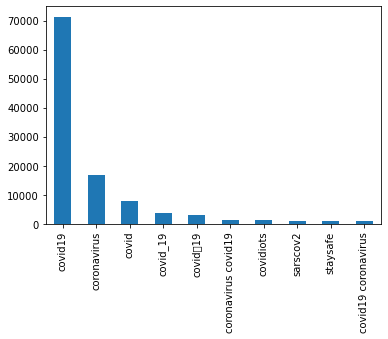

In [84]:
n = 10
frequent_df = df_train['hashtags'].str.lower().copy()
frequent_df = frequent_df.value_counts()[:n]
frequent_df.plot.bar()
#df_train['hashtags'].value_counts()[:n]

In [85]:
#LDA dataframe creation
lda_df = df_train.copy()
lda_df = lda_df.drop(columns=['reply_to_screen_name', 'is_quote', 'is_retweet', 'hashtags', 
             'country', 'tweet_length', 'hashtag_length'])
lda_df['text_processed'] = lda_df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
lda_df['text_processed'] = lda_df['text_processed'].map(lambda x: x.lower())
#lda_df.head()

In [86]:
number_topics = 10
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(lda_df['text_processed'])
lda = LDA(n_components=number_topics)
lda.fit(count_data)

LatentDirichletAllocation()

In [87]:
number_words = 10
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words -1:-1]]))
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
covid19 amp https tco health symptoms america people flu pandemic

Topic #1:
tco https covid19 amp covid mask masks face wear spread

Topic #2:


/Users/revan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


covid19 tco https trump coronavirus amp realdonaldtrump vaccine people americans

Topic #3:
tco https la el en covid19 que coronavirus por staysafe

Topic #4:
covid19 cases https tco new deaths coronavirus day days people

Topic #5:
covid19 tco https amp people covid health home test testing

Topic #6:
tco https covid19 coronavirus amp pandemic new help covid support

Topic #7:
https tco coronavirus covid19 la le les covidiots et en

Topic #8:
covid19 coronavirus people covid auspol tco https amp just china

Topic #9:
tco https covid19 covid 19 coronavirus staysafe patients amp 2020


In [88]:
STOP_WORDS = set(stopwords.words('english'))
english_punctuations = string.punctuation
punctuations_list = english_punctuations
translator = str.maketrans('', '', punctuations_list)
tokenizer = RegexpTokenizer(r'\w+')
st = nltk.PorterStemmer()
lmtzr = WordNetLemmatizer()

In [90]:
 Emoji_Pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

def clean_text(text_str):
    text_str = text_str.lower()
    text_str = re.sub(r"http\S+", "", text_str) #removes links
    text_str = re.sub(r'\d+',"", text_str)
    text_str = re.sub(r'[^\w\s]', " ", text_str) #removes punctuation
    text_str = remove_emojis(text_str)
    tokens = nltk.word_tokenize(text_str)
    tokens = [word for word in tokens if word not in STOP_WORDS and len(word) > 2]
    lemmas = [lemmatizer.lemmatize(word, pos= 'v') for word in tokens]
    return ' '.join(lemmas)

def remove_emojis(tweet):
    return Emoji_Pattern.sub(r'', tweet)

In [91]:
df_train["clean_text"] = df_train["text"].map(clean_text)
df_test["clean_text"] = df_test["text"].map(clean_text)

In [92]:
df_train[["clean_text", "text"]].head(10)

,clean_text,text
0,remember wuhancoronavirus pandemic great perce...,Remember the #WuhanCoronaVirus? The pandemic w...
1,source whitehouse say tactics use get america ...,My sources @WhiteHouse say 2 tactics will be u...
2,venture wild guess run usa covid crisis want s...,I'll venture a wild guess: If you were running...
3,pakistan greenstimulus nature protection green...,#Pakistan (#GreenStimulus = #Nature protection...
4,pandémie coronavirus pasteurs américains qui a...,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...
5,make meme corona virus meme coronavirusmeme to...,So I made a meme....#corona #virus #meme #coro...
6,first saw revise cdc figure list fewer america...,When I first saw the revised CDC figure—which ...
7,one really listen blacklifematters covid stopp...,"Um, no one’s really listening to you. #blackli..."
8,cmotamilnadu அரச arivalayam corona அரச aiadmko...,ஆக்கப்பூர்வமான யோசனையை @CMOTamilNadu அரசுக்கு ...
9,academy might postpone oscars theacademy acade...,The Academy Might Be Postponing The Oscars\n\n...


In [95]:
le = preprocessing.LabelEncoder()
le.fit(df_train['country'])
df_train['country_code'] = le.transform(df_train['country'])

,country,country_code
239990,new_zealand,3
239991,new_zealand,3
239992,new_zealand,3
239993,new_zealand,3
239994,new_zealand,3
239995,new_zealand,3
239996,new_zealand,3
239997,new_zealand,3
239998,new_zealand,3
239999,new_zealand,3


In [96]:
df_test.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,Id,tweet_length,clean_text
0,"Ethical investing is not optional anymore, say...",NaN,False,False,covid19,0,211,ethical invest optional anymore say sri julia ...
1,#COVID19 | Suite à la conférence de presse du ...,NaN,False,True,COVID19,1,207,covid suite conférence presse premier ministre...
2,"Yesterday, I had a live discussion with @Steve...",NaN,False,True,COVID19,2,259,yesterday live discussion stevefda covid assur...
3,Nepal - #Coronavirus cases up 24% in a week. D...,NaN,False,True,Coronavirus,3,134,nepal coronavirus case week deaths total case ...
4,American economy jumped up a % big news story...,NaN,False,False,LysolAndCloroxSales,4,250,american economy jump big news story whole lys...


In [97]:
df_train.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country,tweet_length,hashtag_length,clean_text,country_code
0,Remember the #WuhanCoronaVirus? The pandemic w...,NaN,False,True,WuhanCoronaVirus KillerCuomo,us,267,28,remember wuhancoronavirus pandemic great perce...,5
1,My sources @WhiteHouse say 2 tactics will be u...,NaN,False,True,Trump,us,281,5,source whitehouse say tactics use get america ...,5
2,I'll venture a wild guess: If you were running...,NaN,False,True,COVID19,us,292,7,venture wild guess run usa covid crisis want s...,5
3,#Pakistan (#GreenStimulus = #Nature protection...,NaN,False,True,Pakistan GreenStimulus Nature Green,us,236,35,pakistan greenstimulus nature protection green...,5
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...,NaN,False,True,coronavirus COVID__19 COVIDー19,us,279,30,pandémie coronavirus pasteurs américains qui a...,5


In [98]:
x_train = df_train['clean_text'].tolist()
y_train = df_train['country_code'].tolist()

In [121]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#vectorizer = TfidfVectorizer(analyzer='word',max_features=5000,lowercase=False)
vectorizer = TfidfVectorizer(ngram_range = (1,2),stop_words='english')
vectorizer.fit(x_train)
classifier = MultinomialNB()
classifier.fit(vectorizer.transform(X_train),Y_train)
classifier.score(vectorizer.transform(X_test),Y_test)

In [ ]:
Seed = 123
dt = DecisionTreeClassifier(random_state=123)
dt.fit(vectorizer.transform(X_train),Y_train)
dt.score(vectorizer.transform(X_test),Y_test)

In [123]:
def create_output(df_test, y_predict):
    df_out = df_test['Id'].copy()
    df_out['country_code'] = y_predict
    df_out["country"] = le.inverse_transform(df_out['country'])
    df_out.to_csv("/Users/revan/Downloads/kaggle_submission.csv", index=False)
    print(df_out.head(10))